In [106]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('mps')

## Prepare data

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
file = 'data/spa.txt'

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    try:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH #and \
#            p[0].startswith(eng_prefixes)
    except:
        print(p)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, file):
    text = open(file, encoding='utf-8').read().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in text ]
    pairs = [pair for pair in pairs if len(pair) == 2]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    pairs = filterPairs(pairs)
    
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


In [10]:
input_lang, output_lang, pairs = prepareData('eng', 'spa', file)

Counted words:
eng 12105
spa 23411


In [141]:
input_lang1, output_lang1, pairs1 = prepareData('eng', 'spa', file)

Counted words:
eng 13789
spa 26915


## Network

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Preparing training data

In [13]:
pairs[:20]

[['go', 've'],
 ['go', 'vete'],
 ['go', 'vaya'],
 ['go', 'vayase'],
 ['hi', 'hola'],
 ['run !', 'corre !'],
 ['run !', 'corran !'],
 ['run !', 'huye !'],
 ['run !', 'corra !'],
 ['run !', 'corred !'],
 ['run', 'corra'],
 ['run', 'corred'],
 ['who ?', 'quien ?'],
 ['wow !', 'orale !'],
 ['duck !', 'inclinate !'],
 ['duck !', 'agachate !'],
 ['duck !', 'agachese !'],
 ['duck !', 'agachense !'],
 ['duck !', 'agachaos !'],
 ['fire !', 'fuego !']]

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'spa', file)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Training

In [16]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Counted words:
eng 12105
spa 23411
8m 37s (- 129m 29s) (5 6%) 1.7811
31m 50s (- 222m 55s) (10 12%) 0.9807
42m 26s (- 183m 54s) (15 18%) 0.7358
61m 32s (- 184m 38s) (20 25%) 0.6122
70m 7s (- 154m 16s) (25 31%) 0.5370
125m 15s (- 208m 45s) (30 37%) 0.4852
154m 35s (- 198m 46s) (35 43%) 0.4472
163m 12s (- 163m 12s) (40 50%) 0.4182
171m 44s (- 133m 34s) (45 56%) 0.3949
180m 30s (- 108m 18s) (50 62%) 0.3759
221m 36s (- 100m 43s) (55 68%) 0.3602
304m 59s (- 101m 39s) (60 75%) 0.3466
379m 58s (- 87m 41s) (65 81%) 0.3349
454m 27s (- 64m 55s) (70 87%) 0.3250
463m 2s (- 30m 52s) (75 93%) 0.3162
519m 2s (- 0m 0s) (80 100%) 0.3083


<Figure size 640x480 with 0 Axes>

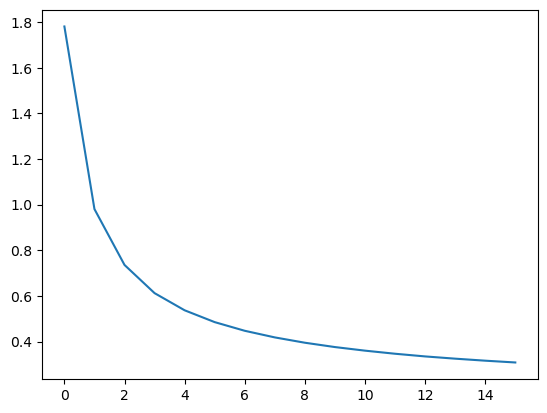

In [178]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [187]:
path = "./models/"
torch.save(encoder, path+"translate_sp_en_encoder.pt")
torch.save(decoder, path+"translate_sp_en_decoder.pt")

### Evaluate 

In [29]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [28]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [179]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> you re three years younger than tom
= eres tres anos menor que tom
< eres tres anos mas que pase <EOS>

> i m pleased to see you
= me alegra verte
< estoy contento de verte <EOS>

> i am responsible for the mistake
= yo soy responsable del error
< soy responsable del accidente del rompecabezas <EOS>

> he s stupid
= es un salame
< es estupido de estupido <EOS>

> i m very short of money
= estoy corto de dinero
< estoy corto de dinero <EOS>

> i m sure i saw her two years ago
= estoy seguro de que la vi hace dos anos
< estoy seguro de que haya visto llorar <EOS>

> i m hungry and thirsty
= estoy hambrienta y sedienta
< tengo hambre y muero muero que los autobuses <EOS>

> he is in touch with all kinds of people
= el se codea con todo tipo de gente
< el vive en el futuro de frances <EOS>

> she is going to learn how to drive
= ella va a aprender a conducir
< ella va a aprender a conducir un camino <EOS>

> i m hoping to sell my car for
= espero poder vender el coche por dolares
< esper

In [180]:
 evaluate(encoder, decoder, 'he is my brother', input_lang, output_lang)

(['el', 'es', 'mi', 'hermano', 'mayor', '<EOS>'], None)

In [181]:
evaluate(encoder, decoder, 'she is my sister', input_lang, output_lang)

(['ella', 'es', 'mi', 'hermana', 'mayor', '<EOS>'], None)

In [182]:
evaluate(encoder, decoder, 'she is a teacher', input_lang, output_lang)

(['es', 'el', 'profesor', '<EOS>'], None)

In [35]:
evaluate(encoder, decoder, 'we are students', input_lang, output_lang)

(['somos', 'estudiantes', 'por', 'los', 'estudiantes', '<EOS>'], None)

In [36]:
evaluate(encoder, decoder, 'i am a cook', input_lang, output_lang)

(['soy', 'un', 'cocinero', 'dificil', '<EOS>'], None)

In [37]:
evaluate(encoder, decoder, 'i am cleaning my house', input_lang, output_lang)

(['estoy', 'contento', 'de', 'mi', 'casa', 'es', 'verde', '<EOS>'], None)

In [40]:
evaluate(encoder, decoder, 'she is an idiot', input_lang, output_lang)

(['es', 'un', 'idiota', '!', '<EOS>'], None)

## Attention model

In [19]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [24]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder_attn = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_attn = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder_attn, decoder_attn, 80, print_every=5, plot_every=5)

Counted words:
eng 12105
spa 23411
10m 8s (- 152m 7s) (5 6%) 1.4922
20m 25s (- 143m 0s) (10 12%) 0.7396
30m 23s (- 131m 40s) (15 18%) 0.5663
40m 15s (- 120m 47s) (20 25%) 0.4839
50m 20s (- 110m 45s) (25 31%) 0.4328
60m 19s (- 100m 33s) (30 37%) 0.3970
70m 13s (- 90m 17s) (35 43%) 0.3707
80m 6s (- 80m 6s) (40 50%) 0.3497
89m 58s (- 69m 58s) (45 56%) 0.3334
99m 48s (- 59m 53s) (50 62%) 0.3191
109m 37s (- 49m 49s) (55 68%) 0.3077
119m 29s (- 39m 49s) (60 75%) 0.2975
129m 21s (- 29m 51s) (65 81%) 0.2896
139m 14s (- 19m 53s) (70 87%) 0.2818
149m 7s (- 9m 56s) (75 93%) 0.2754
238m 30s (- 0m 0s) (80 100%) 0.2696


In [26]:
path = "./models/"
torch.save(encoder_attn, path+"translate_sp_en_attn_encoder.pt")
torch.save(decoder_attn, path+"translate_sp_en_attn_decoder.pt")

In [30]:
encoder_attn.eval()
decoder_attn.eval()
evaluateRandomly(encoder_attn, decoder_attn)

> she can swim as fast as her brother
= sabe nadar tan rapido como su hermano
< ella sabe nadar tan rapido como su hermano <EOS>

> stop being lazy and find something to do
= deja de ser perezoso y encuentra algo que hacer
< deja de ser perezoso y encuentra algo <EOS>

> tom ll find out
= tom lo averiguara
< tom lo averiguara probablemente <EOS>

> tom filled the three glasses with orange juice
= tom lleno los tres vasos con jugo de naranja
< tom lleno los tres vasos con jugo de naranja <EOS>

> we ve got to do that on monday
= tenemos que hacerlo el lunes
< tenemos que hacerlo el lunes <EOS>

> it s finally october
= al fin es octubre
< al fin es octubre mucho <EOS>

> the tree s leaves have all fallen
= cayeron todas las hojas del arbol
< el arbol me han vuelto todas toda la <EOS>

> two detectives followed the suspect
= dos detectives persiguieron al sospechoso
< dos detectives persiguieron al sospechoso <EOS>

> they re not going to leave us alone
= no nos van a dejar en paz
< no n

In [31]:
encoder = torch.load(path+"translate_sp_en_encoder.pt")
decoder = torch.load(path+"translate_sp_en_decoder.pt")

In [45]:
evaluate(encoder, decoder, 'i m studying in an english class', input_lang, output_lang)[0]

['estoy', 'estudiando', 'ingles', 'en', 'el', 'estudio', '<EOS>']

In [44]:
evaluate(encoder_attn, decoder_attn, 'i m studying in an english class', input_lang, output_lang)[0]

['estoy', 'estudiando', 'en', 'una', 'clase', 'de', 'ingles', '<EOS>']

In [46]:
evaluate(encoder, decoder, 'my brother never showed up in my party', input_lang, output_lang)[0]

['mi', 'hermano', 'nunca', 'se', 'fue', 'en', 'mi', 'fiesta', '<EOS>']

In [47]:
evaluate(encoder_attn, decoder_attn, 'my brother never showed up in my party', input_lang, output_lang)[0]

['mi', 'hermano', 'nunca', 'se', 'porto', 'en', 'mi', 'fiesta', 'de', 'mi']

In [48]:
 evaluate(encoder, decoder, 'he is my brother', input_lang, output_lang)

(['el', 'es', 'mi', 'hermano', 'mayor', '<EOS>'], None)

In [54]:
evaluate(encoder_attn, decoder_attn, 'what is your name ?', input_lang, output_lang)[0]

['como', 'se', 'llama', 'tu', 'nombre', '?', '<EOS>']

In [55]:
evaluate(encoder_attn, decoder_attn, 'what is my name ?', input_lang, output_lang)[0]

['como', 'le', 'llama', 'mi', 'nombre', '?', '<EOS>']

In [59]:
evaluate(encoder, decoder, 'what is his name ?', input_lang, output_lang)[0]

['como', 'se', 'llama', 'tu', 'nombre', '?', '<EOS>']

In [56]:
evaluate(encoder_attn, decoder_attn, 'what is his name ?', input_lang, output_lang)[0]

['como', 'se', 'llama', 'su', 'nombre', '?', '<EOS>']

In [57]:
evaluate(encoder_attn, decoder_attn, 'what is her name ?', input_lang, output_lang)[0]

['como', 'le', 'llama', 'el', 'nombre', '?', '<EOS>']

In [62]:
evaluate(encoder_attn, decoder_attn, 'my car broke down this week', input_lang, output_lang)[0]

['mi', 'coche', 'me', 'esta', 'romper', 'esta', 'semana', '<EOS>']

In [63]:
evaluate(encoder, decoder, 'my car broke down this week', input_lang, output_lang)[0]

['mi', 'coche', 'esta', 'en', 'el', 'coche', 'de', 'mi', 'nombre', 'aun']

In [69]:
evaluate(encoder_attn, decoder_attn, 'how is it going ?', input_lang, output_lang)[0]

['como', 'va', '?', '<EOS>']

In [70]:
evaluate(encoder, decoder, 'how is it going ?', input_lang, output_lang)[0]

['como', 'va', '?', '<EOS>']

In [71]:
evaluate(encoder_attn, decoder_attn, 'what s up ?', input_lang, output_lang)[0]

['que', 'esta', 'casado', '?', '<EOS>']

In [72]:
evaluate(encoder, decoder, 'what s up ?', input_lang, output_lang)[0]

['que', 'esta', 'es', '?', '<EOS>']

In [77]:
evaluate(encoder_attn, decoder_attn, 'who ?', input_lang, output_lang)[0]

['quien', 'es', 'la', 'culpa', '?', '<EOS>']

In [78]:
evaluate(encoder, decoder, 'who ?', input_lang, output_lang)[0]

['quien', 'se', 'quien', 'es', '?', '<EOS>']

In [98]:
evaluate(encoder_attn, decoder_attn, 'go', input_lang, output_lang)[0]

['vayase', 'por', 'la', 'noche', '<EOS>']

In [99]:
evaluate(encoder, decoder, 'go', input_lang, output_lang)[0]

['anda', 'en', 'ir', '<EOS>']

In [92]:
evaluate(encoder_attn, decoder_attn, 'i am thirty years old', input_lang, output_lang)[0]

['tengo', 'treinta', 'anos', 'edad', '<EOS>']

In [88]:
evaluate(encoder, decoder, 'i am thirty two years old', input_lang, output_lang)[0]

['estoy', 'viviendo', 'y', 'dos', 'opciones', '<EOS>']

In [97]:
pairs[:10]

[['go', 've'],
 ['go', 'vete'],
 ['go', 'vaya'],
 ['go', 'vayase'],
 ['hi', 'hola'],
 ['run !', 'corre !'],
 ['run !', 'corran !'],
 ['run !', 'huye !'],
 ['run !', 'corra !'],
 ['run !', 'corred !']]

### Visualizing attention

In [113]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder_attn, decoder_attn, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

input = so what ?
output = entonces que lo que ? <EOS>


/var/folders/nh/g297r9mj48l7bfzrbr59bg4m0000gn/T/ipykernel_55123/863452007.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/nh/g297r9mj48l7bfzrbr59bg4m0000gn/T/ipykernel_55123/863452007.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


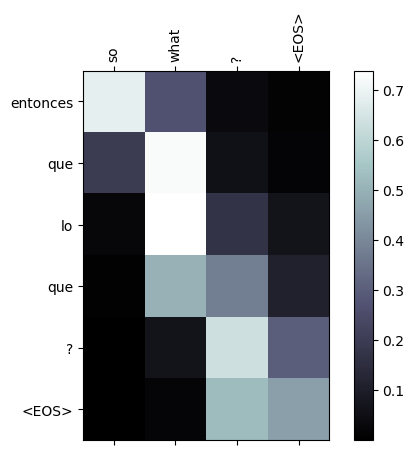

In [122]:
evaluateAndShowAttention('so what ?')